In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

ORDER = [0, 2, 3, 1] # Full, Social, Transition, Launcher
version = 'v6_IRLS'

# Panel a

In [5]:
all_age_res = loadmat(f'../../../all_age_gender_log_{version}.mat')['all_age_gender'][0]  # 4 structs for 4 JIDs

In [6]:
data_it = all_age_res[2].flat[0][0].flat[0]
A = data_it[3].squeeze().reshape(-1, 50, 50).T
print(A.shape)
B = data_it[4].squeeze()
print(B.shape)

(50, 50, 499)
(499, 3)


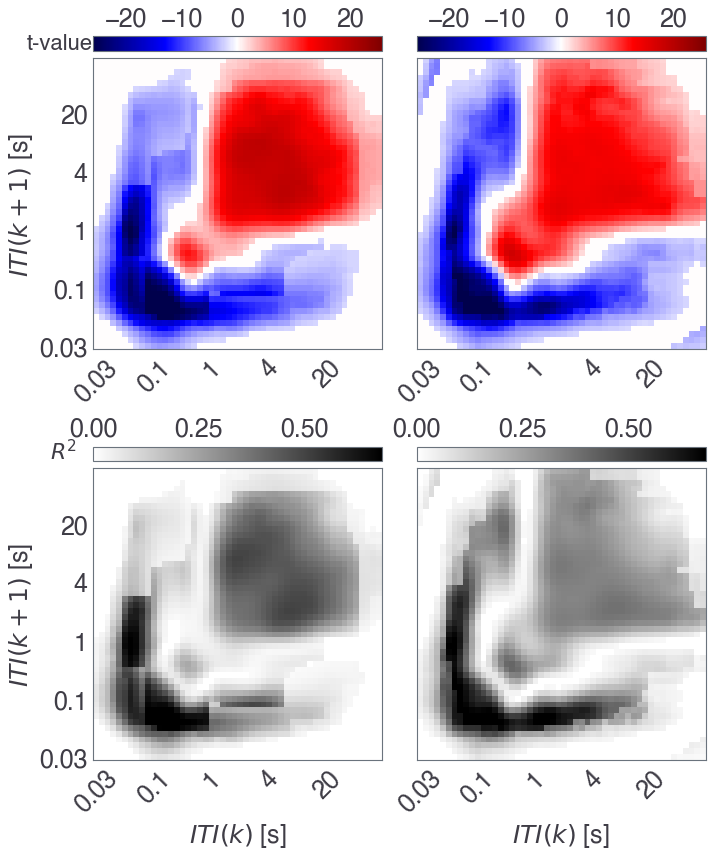

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 12), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(2):
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]


    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social']):

    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-12, 51, 't-value', size=22)    
ax[1][0].text(-8, 51, r'$R^2$', size=22)    
plt.tight_layout()
plt.savefig('figure_3_panel_a.pdf', transparent=True)

# Panel b

<ipython-input-8-57b883f44138>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,JID,N,p-value,f-value,beta,R2
0,Full,515,0.0,505.552056,-0.037693,0.771566
1,Social,499,0.0,468.353715,-0.048593,0.765157


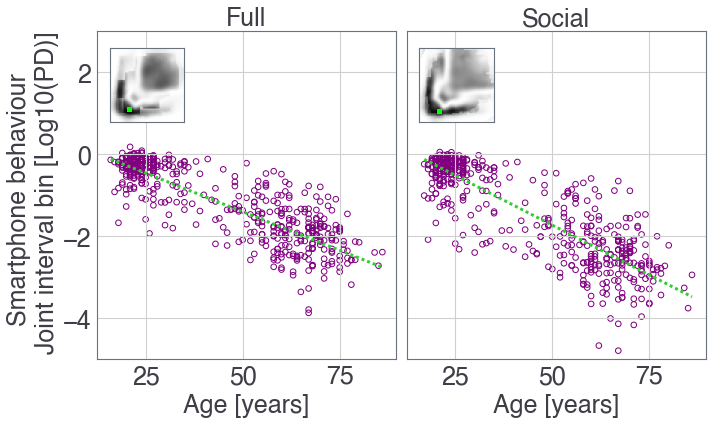

In [8]:
df_fig3panb = pd.DataFrame(columns={'JID', 'N', 'R2', 'p-value', 'f-value', 'beta'})
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, _title in enumerate(['Full', 'Social']):
    
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    A = data_it[3].squeeze()
    B = data_it[4].squeeze()
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    
    idx = np.argmax(r2_full)
    _y = A[:, idx]
    _x = B[:, 0]
    _k = betas[idx]
    
    ax[i].scatter(_x, _y, facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[i].plot([_x.min(), _x.max()], np.array([_x.min(), _x.max()]) * _k[0] + _k[2], 'limegreen', dashes=[1, 1], linewidth=3, label="Linear Fit")
    
    ax[i].set_ylim([-5, 3])
    ax[i].set_title(_title)
    ax[i].set_xlabel("Age [years]")

    df_fig3panb = df_fig3panb.append({'JID': _title, 'N': len(_x), 
                                      'R2': r2_full[idx], 'p-value': p_full[idx], 
                                      'f-value': f_full[idx], 'beta':_k[0]}, ignore_index=True)
    
    inset_ax = inset_axes(ax[i],
                          height="25%", # set height
                          width="25%", # and width
                          loc='upper left') # center, you can check the different codes in plt.legend?
    inset_ax.imshow(r2_full.reshape(50, 50).T, cmap='binary')
    inset_ax.xaxis.set_visible(False)
    inset_ax.yaxis.set_visible(False)
    inset_ax.grid(False)
    inset_ax.invert_yaxis()
    x1 = idx % 50
    y1 = idx // 50;
    rect1 = matplotlib.patches.Rectangle((y1, x1), 2, 2, linewidth=2, edgecolor='lime', facecolor='lime')
    inset_ax.add_patch(rect1)
    
ax[0].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]");
plt.tight_layout()
plt.savefig("figure_3_panel_b.pdf", transparent=True)
df_fig3panb.to_csv('figure_3_panel_b.csv', index=False)
df_fig3panb

# Supplementary a.i.

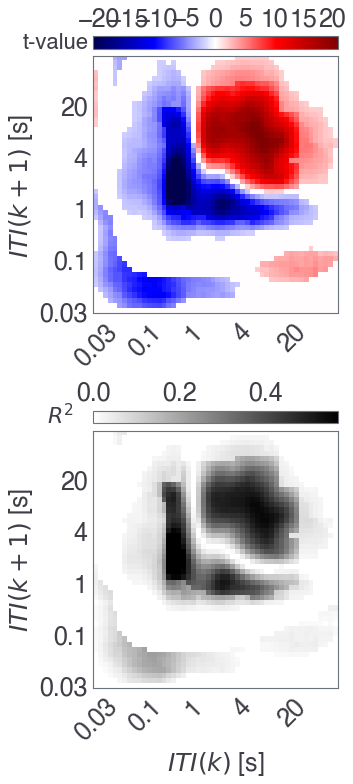

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(5, 11), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(2):
    data_it = all_age_res[3].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]


    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Transition']):

    data_it = all_age_res[3].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[0].invert_yaxis()
    ax[0].set_xticks(ticks)
    ax[0].set_xticklabels(labels)
    ax[0].xaxis.set_tick_params(rotation=45)
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0].grid(False)
    divider = make_axes_locatable(ax[0])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[1].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[1].invert_yaxis()
    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels)
    ax[1].xaxis.set_tick_params(rotation=45)
    ax[1].set_yticks(ticks)
    ax[1].set_yticklabels(labels)
    ax[1].set_xlabel(r'$ITI(k)$ [s]')
    ax[1].grid(False)
    divider = make_axes_locatable(ax[1])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-15, 51, 't-value', size=22)    
ax[1].text(-10, 51, r'$R^2$', size=22)    
plt.tight_layout()
plt.savefig('figure_3_supplementary_a_i.pdf', transparent=True)

# Supplementary a.ii.

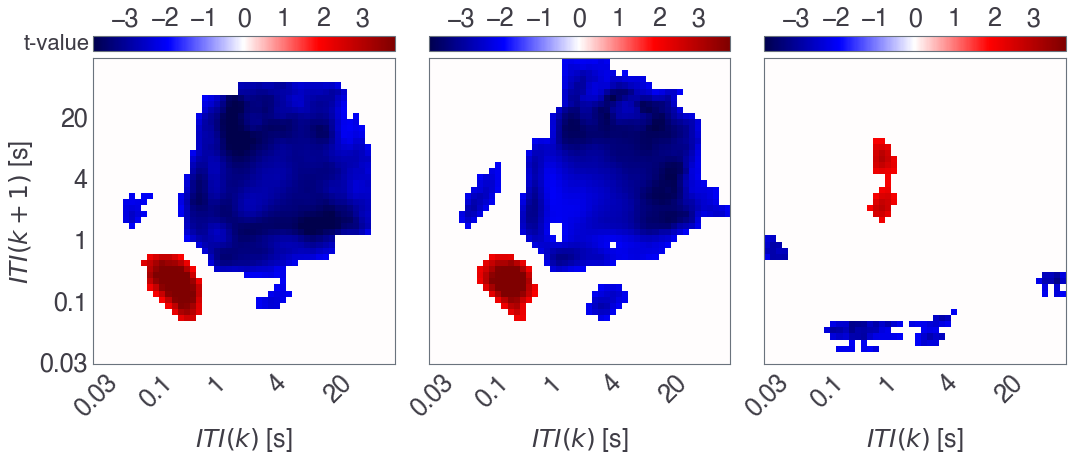

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6.5), sharey=True)
    
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(3):
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 1].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 1].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.max(r2_full))
    vmin_r = min(vmin_r, np.min(r2_full))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition']):

    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    k = betas[:, 1].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 1].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[i].imshow(np.sign(masks_uni[1]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[i].invert_yaxis()
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].set_xlabel(r'$ITI(k)$ [s]')
    ax[i].grid(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()

ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-12, 51, 't-value', size=22)    
plt.tight_layout()
plt.savefig('figure_1_supplementary_a_ii.pdf', transparent=True)

# Supplementary x.i.

8


,N,p-value,f-value,beta,R2
0,352.0,1.124615e-22,NaN,NaN,0.257007


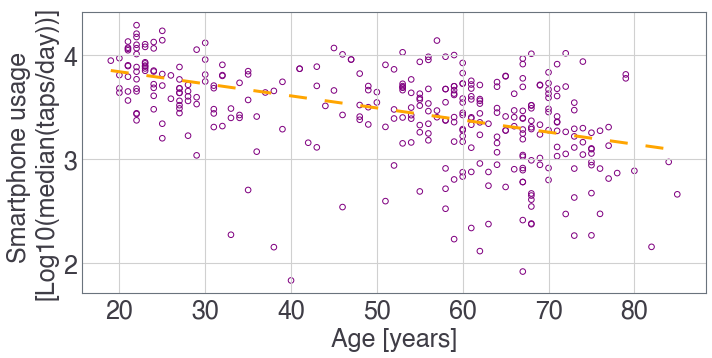

In [15]:
df_fig1suppiii = pd.DataFrame(columns={'N', 'R2', 'p-value', 'f-value', 'beta'})
adjusted = loadmat('../../../suppl_iii.mat')['adjusted'].flat[0]
print(len(adjusted))

adjusted_fit = adjusted[0]
adjusted_data = adjusted[1]
usage = adjusted[2]
age = adjusted[3]
gender = adjusted[4]
r2 = adjusted[6][0][0]
pval = adjusted[7][0][0]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(adjusted_data[0], adjusted_data[1], facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
ax.plot(adjusted_fit[0], adjusted_fit[1], 'orange', dashes=[6, 6], linewidth=3, label="Linear Fit")
ax.set_xlabel('Age [years]')

df_fig1suppiii = df_fig1suppiii.append({'N': len(adjusted_data[0]), 
                                      'R2': r2, 'p-value': pval, 
                                      'f-value': np.nan, 'beta': np.nan}, ignore_index=True)

# ax.text(17, 1.8, f"R2 = {r2:.2f} \np-val = {pval:.2e}", fontsize=20)
ax.set_ylabel("Smartphone usage \n[Log10(median(taps/day))]")
plt.tight_layout()
plt.savefig('figure_3_supplementary_x_i.pdf')
df_fig1suppiii.to_csv('figure_3_supplementary_x_i.csv', index=False)
df_fig1suppiii

# Supplementary x.ii.

In [17]:
pix_usage = loadmat(f'../../../all_age_gender_usage_pixel_v5_IRLS.mat')['all_age_gender_usage_pixel'][0]
print(len(pix_usage))

4


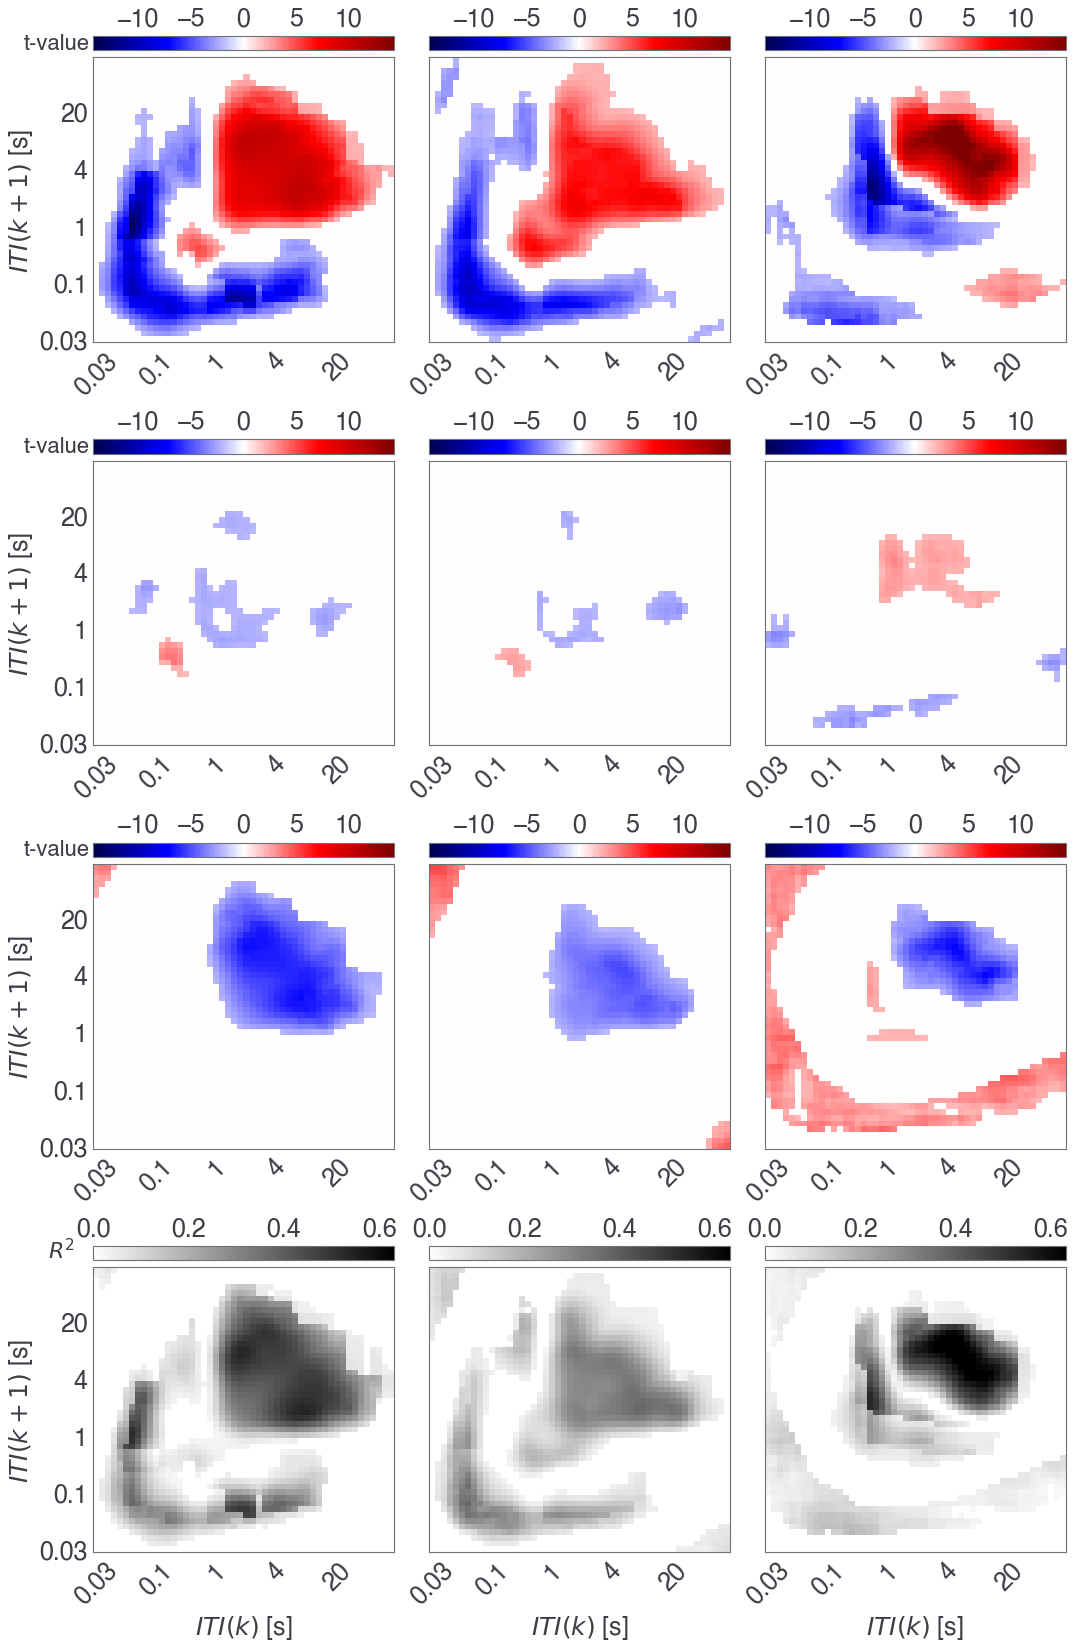

In [21]:
fig, ax = plt.subplots(4, 3, figsize=(15, 23), sharey=True, )

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(3):
    data_it = pix_usage[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 3))
    p_uni = np.zeros((2500, 3))
    betas = np.zeros((2500, 4))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]

    for jj in range(3):

        k = betas[:, jj].reshape(50, 50).T  # T cause of matlab
        square_f = f_uni[:, jj].reshape(50, 50).T
        square_r2_full = r2_full.reshape(50, 50).T
        square_f[square_f < 0] = 0

        vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
        vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))

        vmax_r = max(vmax_r, np.percentile(r2_full, 99))
        vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition']):

    data_it = pix_usage[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 3))
    p_uni = np.zeros((2500, 3))
    betas = np.zeros((2500, 4))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    for jj in range(3):
        k = betas[:, jj].reshape(50, 50).T  # T cause of matlab
        square_f = f_uni[:, jj].reshape(50, 50).T
        square_r2_full = r2_full.reshape(50, 50).T
        square_f[square_f < 0] = 0

        im = ax[jj][i].imshow(np.sign(masks_uni[jj]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                             cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

        ax[jj][i].invert_yaxis()
        ax[jj][i].set_xticks(ticks)
        ax[jj][i].set_xticklabels(labels)
        ax[jj][i].xaxis.set_tick_params(rotation=45)
        ax[jj][i].set_yticks(ticks)
        ax[jj][i].set_yticklabels(labels)
    #     ax[0][i].set_xlabel('ITI(k) [s]')
        ax[jj][i].grid(False)
        divider = make_axes_locatable(ax[jj][i])
        cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
        fig.add_axes(cax)
        cb = fig.colorbar(im, cax=cax, orientation="horizontal")
        cb.ax.xaxis.set_ticks_position('top')
        _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[3][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[3][i].invert_yaxis()
    ax[3][i].set_xticks(ticks)
    ax[3][i].set_xticklabels(labels)
    ax[3][i].xaxis.set_tick_params(rotation=45)
    ax[3][i].set_yticks(ticks)
    ax[3][i].set_yticklabels(labels)
    ax[3][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[3][i].grid(False)
    divider = make_axes_locatable(ax[3][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[2][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[3][0].set_ylabel(r'$ITI(k + 1)$ [s]');

ax[0][0].text(-12, 51, 't-value', size=22)   
ax[1][0].text(-12, 51, 't-value', size=22)   
ax[2][0].text(-12, 51, 't-value', size=22)   
ax[3][0].text(-8, 51, r'$R^2$', size=22)    

plt.tight_layout()
plt.savefig('figure_3_supplementary_x_ii.pdf', transparent=True)

# Supplementary b.i.

<ipython-input-24-500cdee4cbfc>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,JID,N,p-value,f-value,beta,R2
0,Transition,502,0.0,374.001424,-0.024105,0.708894


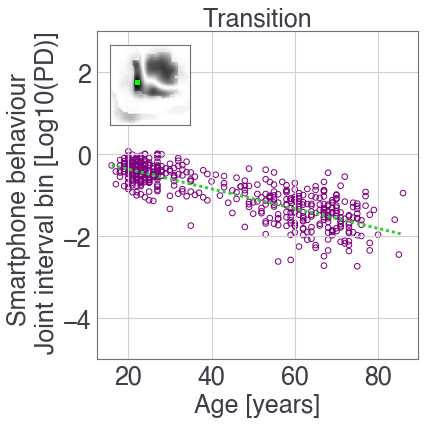

In [24]:
df_fig3panb = pd.DataFrame(columns={'JID', 'N', 'R2', 'p-value', 'f-value', 'beta'})
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, _title in enumerate(['Transition']):
    
    data_it = all_age_res[3].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    A = data_it[3].squeeze()
    B = data_it[4].squeeze()
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    
    idx = np.argmax(r2_full)
    _y = A[:, idx]
    _x = B[:, 0]
    _k = betas[idx]
    
    ax.scatter(_x, _y, facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax.plot([_x.min(), _x.max()], np.array([_x.min(), _x.max()]) * _k[0] + _k[2], 'limegreen', dashes=[1, 1], linewidth=3, label="Linear Fit")
    
    ax.set_ylim([-5, 3])
    ax.set_title(_title)
    ax.set_xlabel("Age [years]")

    df_fig3panb = df_fig3panb.append({'JID': _title, 'N': len(_x), 
                                      'R2': r2_full[idx], 'p-value': p_full[idx], 
                                      'f-value': f_full[idx], 'beta':_k[0]}, ignore_index=True)
    
    inset_ax = inset_axes(ax,
                          height="25%", # set height
                          width="25%", # and width
                          loc='upper left') # center, you can check the different codes in plt.legend?
    inset_ax.imshow(r2_full.reshape(50, 50).T, cmap='binary')
    inset_ax.xaxis.set_visible(False)
    inset_ax.yaxis.set_visible(False)
    inset_ax.grid(False)
    inset_ax.invert_yaxis()
    x1 = idx % 50
    y1 = idx // 50;
    rect1 = matplotlib.patches.Rectangle((y1, x1), 2, 2, linewidth=2, edgecolor='lime', facecolor='lime')
    inset_ax.add_patch(rect1)
    
ax.set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]");
plt.tight_layout()
plt.savefig("figure_3_supplementary_b_i.pdf", transparent=True)
df_fig3panb.to_csv('figure_3_supplementary_b_i.csv', index=False)
df_fig3panb

# Supplementary x.iii.

In [26]:
## Need to first run the MATLAB script `entropy_fig1supi.m`
all_age_entropy = loadmat('../../../adjusted_entropy_response.mat')['all_adjusted'][0]

Full : R2 = 0.02 | p-val = 4.86e-01
Social : R2 = 0.03 | p-val = 5.05e-02
Transition : R2 = 0.09 | p-val = 4.11e-07


,JID,N,p-value,f-value,beta,R2
0,Full,420,4.857953e-01,NaN,NaN,0.016558
1,Social,411,5.048720e-02,NaN,NaN,0.030806
2,Transition,412,4.111859e-07,NaN,NaN,0.090460


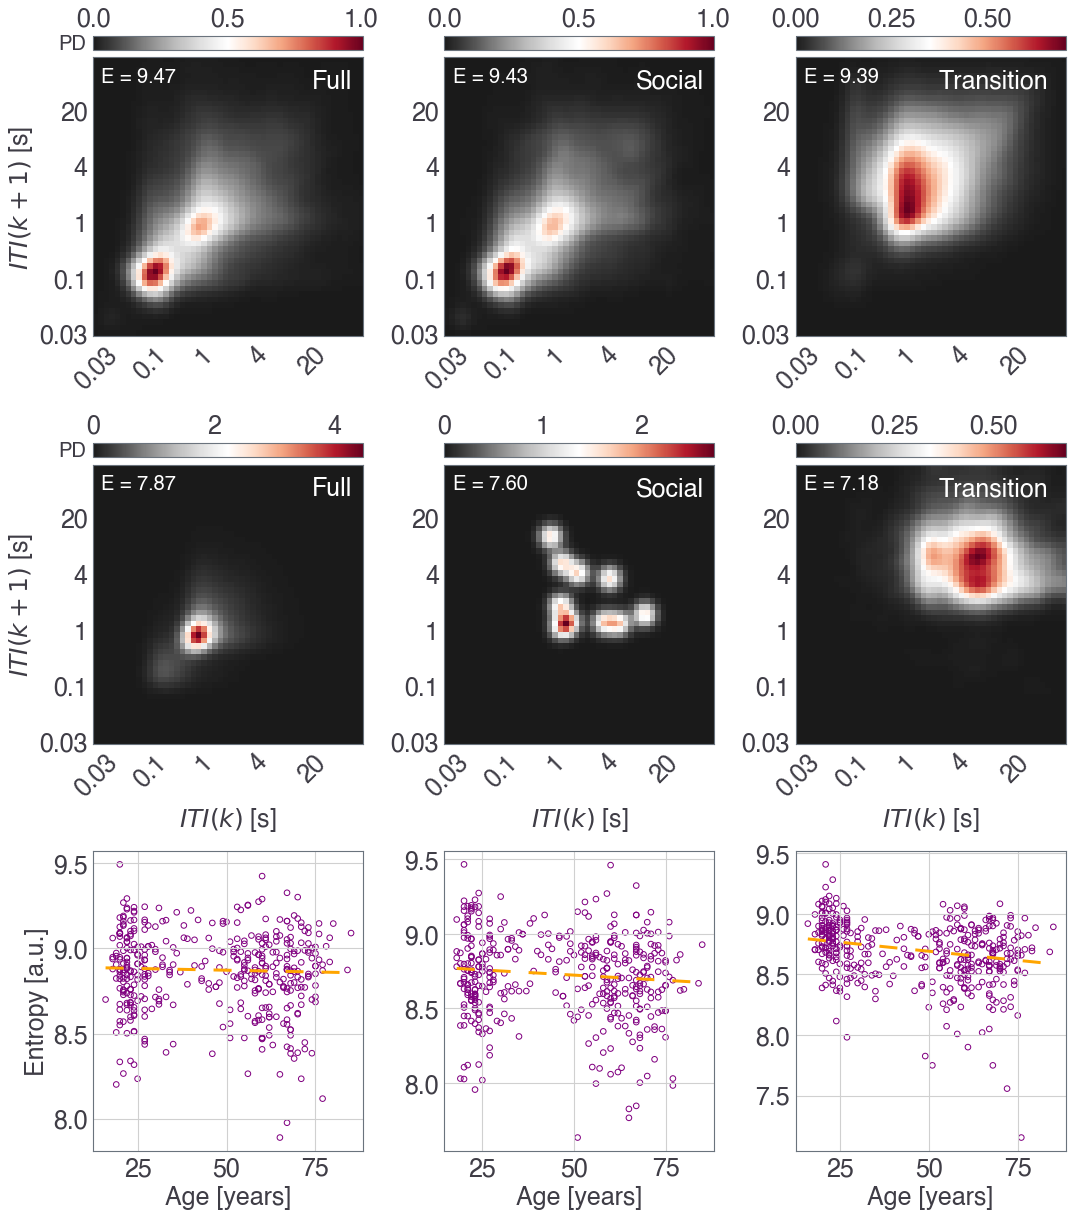

In [30]:
df_fig1suppi = pd.DataFrame(columns={'JID', 'N', 'R2', 'p-value', 'f-value', 'beta'})
fig, ax = plt.subplots(3, 3, figsize=(15, 17))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmin = np.Inf
vmax = -np.Inf

for i in range(3):
    age_entropy = all_age_entropy[ORDER[i]].flat[0]
    adjusted_fit = age_entropy[0]
    adjusted_data = age_entropy[1]
    entropy = age_entropy[2]
    age = age_entropy[3]
    gender = age_entropy[4]
    allJIDs = age_entropy[5]
    r2 = age_entropy[7][0][0]
    pval = age_entropy[8][0][0]
    
    idx_max = np.argmax(entropy)
    idx_min = np.argmin(entropy)
    
    _jid_max = 10 ** allJIDs[idx_max].reshape(50, 50).T
    _jid_min = 10 ** allJIDs[idx_min].reshape(50, 50).T
    
    vmin = min(vmin, np.min(_jid_max))
    vmin = min(vmin, np.min(_jid_min))
    
    vmax = max(vmax, np.max(_jid_max))
    vmax = max(vmax, np.max(_jid_min))

for i, (_title, _ylim, x_bias) in enumerate(zip(['Full', 'Social', 'Transition'], [7.85, 7.6, 7.1], [40, 35, 26])):
    
    age_entropy = all_age_entropy[ORDER[i]].flat[0]
    adjusted_fit = age_entropy[0]
    adjusted_data = age_entropy[1]
    entropy = age_entropy[2]
    age = age_entropy[3]
    gender = age_entropy[4]
    allJIDs = age_entropy[5]
    r2 = age_entropy[7][0][0]
    pval = age_entropy[8][0][0]
    
    idx_max = np.argmax(entropy)
    idx_min = np.argmin(entropy)
    
    _jid_max = 10 ** allJIDs[idx_max].reshape(50, 50).T
    _jid_min = 10 ** allJIDs[idx_min].reshape(50, 50).T
    
    im = ax[0][i].imshow(_jid_max, aspect='auto', cmap='RdGy_r')
#     ax[0][i].set_title(f"{entropy[idx_max][0]:.2f}")
    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
    ax[0][i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    im = ax[1][i].imshow(_jid_min, aspect='auto', cmap='RdGy_r')
#     ax[1][i].set_title(f"{entropy[idx_min][0]:.2f}")
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
    ax[1][i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    
    ax[0][i].text(1, 45, f"E = {entropy[idx_max][0]:.2f}", fontsize=20, color='white')
    ax[1][i].text(1, 45, f"E = {entropy[idx_min][0]:.2f}", fontsize=20, color='white')
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    
    ax[2][i].scatter(adjusted_data[0], adjusted_data[1], facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[2][i].plot(adjusted_fit[0], adjusted_fit[1], 'orange', dashes=[6, 6], linewidth=3, label="Linear Fit")
    ax[2][i].set_xlabel('Age [years]')
    print(f"{_title} : R2 = {r2:.2f} | p-val = {pval:.2e}")
    df_fig1suppi = df_fig1suppi.append({'JID': _title, 'N': len(adjusted_data[0]), 
                                      'R2': r2, 'p-value': pval, 
                                      'f-value': np.nan, 'beta': np.nan}, ignore_index=True)
#     ax[2][i].text(15, _ylim , f"R2 = {r2:.2f} \np-val = {pval:.2e}", fontsize=20)
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0][0].text(-7, 51, 'PD', size=20)
ax[1][0].text(-7, 51, 'PD', size=20)
ax[2][0].set_ylabel("Entropy [a.u.]")
plt.tight_layout()
plt.savefig('figure_3_supplementary_x_iii.pdf', transparent=True)
df_fig1suppi.to_csv('figure_3_supplementary_x_iii.csv', index=False)
df_fig1suppi

# Supplementary x.iv.

In [32]:
all_jid_aut = loadmat(f'../../../all_jid_aut_v5_IRLS.mat')['all_jid_aut'][0]
len(all_jid_aut)

4

In [35]:
min_dist_pix = 5;
th_dist = min_dist_pix * np.sqrt(2);
n_flips = np.zeros((2500, 4))
n_non_flips = np.zeros((2500, 4))
compt_r2 = np.zeros((2500, 4))
th_R2 = 0.1
best_r2 = np.zeros((2500, 6, 4))

for kk in range(3):
    to_avg_r2 = [[] for _ in range(2500)]
    
    # FOR SIGN AGE PIXEL
    val = all_age_res[ORDER[kk]].flat[0][0].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    mdl = val[2]
    r2_full = np.zeros(2500)

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
    
    # AUT
    aut = all_jid_aut[ORDER[kk]].flat[0][0].flat[0]
    mask_aut = aut[0]
    p_vals_aut = aut[1]
    f_vals_aut = aut[2] 
    r_vals_aut = aut[3]
    r2_vals_aut = aut[4]
    betas_aut = aut[5]

    for i in range(2500):
        for j in range(2500):
            if i != j:
                if (r2_full[i] > th_R2) & (r2_full[j] > th_R2) & (mask_aut[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                    x1 = i % 50
                    y1 = i // 50
                    x2 = j % 50
                    y2 = j // 50
                    if betas_aut[i, j, 0] < 0:
                        if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                            _r2 = r2_vals_aut[i, j]
                            n_flips[i, kk] += 1
                            to_avg_r2[i].append(_r2)
                            if _r2 > best_r2[i, 0, kk]:
                                best_r2[i, 0, kk] = _r2
                                best_r2[i, 1, kk] = x1
                                best_r2[i, 2, kk] = y1
                                best_r2[i, 3, kk] = x2
                                best_r2[i, 4, kk] = y2
                                best_r2[i, 5, kk] = 1
                    else:
                        if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                            n_non_flips[i, kk] += 1
                    
    compt_r2[:, kk] = np.array([np.max(i) if len(i) > 0 else 0 for i in to_avg_r2])
    
fmax = np.percentile(n_flips, 99)
rmax = np.percentile(compt_r2, 99)
print((fmax, rmax))
df_fig2suppi = pd.DataFrame(columns={'JID', 'n-flips', 'n-non-flips'})
df_fig2suppi = df_fig2suppi.append({'JID': 'full', 'n-flips': np.sum(n_flips, 0)[0], 'n-non-flips': np.sum(n_non_flips, 0)[0]}, ignore_index=True)
df_fig2suppi = df_fig2suppi.append({'JID': 'social', 'n-flips': np.sum(n_flips, 0)[1], 'n-non-flips': np.sum(n_non_flips, 0)[1]}, ignore_index=True)
df_fig2suppi = df_fig2suppi.append({'JID': 'transition', 'n-flips': np.sum(n_flips, 0)[2], 'n-non-flips': np.sum(n_non_flips, 0)[2]}, ignore_index=True)
df_fig2suppi = df_fig2suppi.append({'JID': 'launcher', 'n-flips': np.sum(n_flips, 0)[3], 'n-non-flips': np.sum(n_non_flips, 0)[3]}, ignore_index=True)
df_fig2suppi.to_csv('figure_3_supplementary_x_iv.csv', index=False)
df_fig2suppi

(801.0, 0.4789556307230578)


,JID,n-flips,n-non-flips
0,full,489658.0,487564.0
1,social,548974.0,733826.0
2,transition,34050.0,33812.0
3,launcher,0.0,0.0


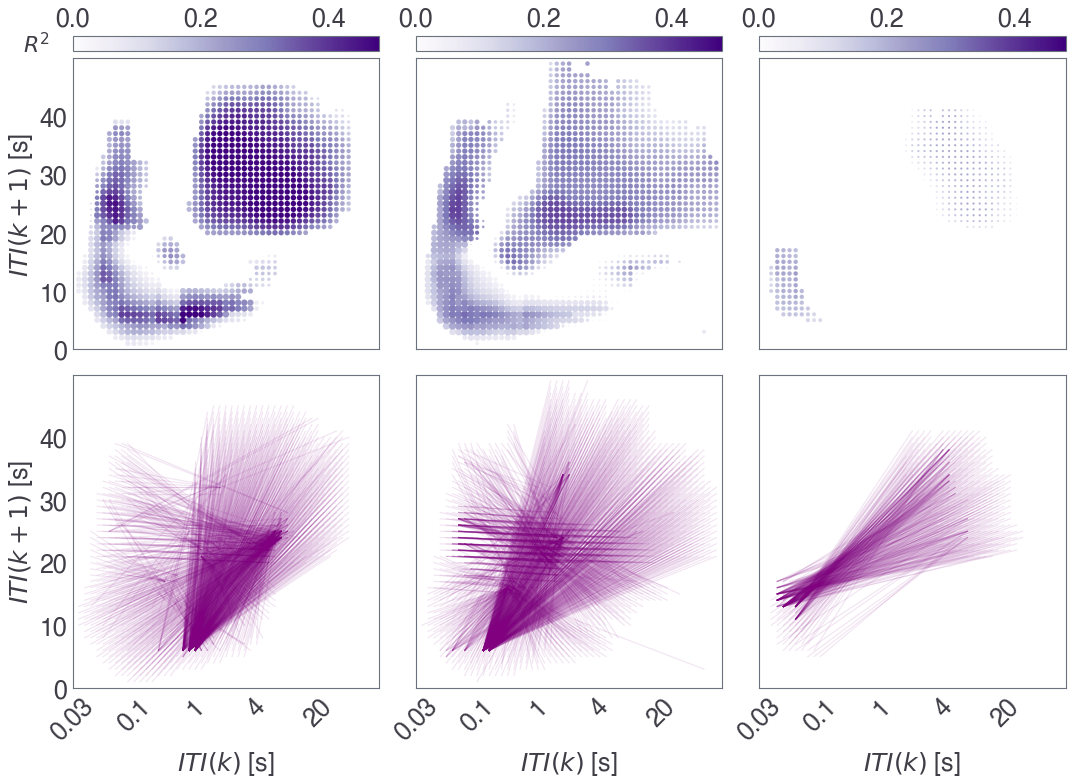

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(15, 11), sharex=True, sharey=True)

X = np.arange(2500) % 50;
Y = np.arange(2500) // 50;
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for kk in range(3):
    
    im = ax[0][kk].scatter(X, Y, s=n_flips[:, kk] / fmax * 50, c=compt_r2[:, kk], cmap='Purples', norm=Normalize(0, vmax=rmax))
    divider = make_axes_locatable(ax[0][kk])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')

    for i in range(2500):
        if best_r2[i, 5, kk] == 1:
            x1, y1, x2, y2 = best_r2[i, 1:5, kk]
            ax[1][kk].plot([x1, x2], [y1, y2], '-', color='purple', alpha=0.1)

    for i in range(2):
        ax[i][kk].grid(False)
        ax[i][kk].set_xticks(ticks)
        ax[i][kk].set_xticklabels(labels)
        ax[i][kk].xaxis.set_tick_params(rotation=45)
        ax[i][kk].set_yticks(ticks)
        ax[i][kk].set_xlim([0, 50])
        ax[i][kk].set_ylim([0, 50])
        if i == 1:
            ax[i][kk].set_xlabel(r'$ITI(k)$ [s]')
        if kk == 0:
            ax[i][kk].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0][0].text(-8, 51, r'$R^2$', size=22)  
plt.tight_layout()
plt.savefig('figure_3_supplementary_x_iv.pdf', transparent=True)